In [1]:
#For downloads
import gdown, os, gzip, shutil

# Basic data management and plotting
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import os

# Scanpy fundamentals
import anndata as ad
import scanpy as sc
import seaborn as sb

# sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(figsize=(6, 6))
import scvi

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# Preprocessing - Quality control

Data cleaning is the first step in preprocessing scRNA-seq data. Its goal is to identify and remove cells that may not meet certain quality standarts, ensuring that the data used in downstream analysis is as reliable and accurate as possible. 

In single-cell experiments, not all cell produce high quality data. Some cells might be dead, damaged or compromised due to technical error during the experiment. If these low quality cells aren´t removed, they can introduce noise and skew the analysis, leading to incorrect conclusions. Data cleaning helps address these issues by filtering out problematic cells early in the process. 

First, we remove cells with high mitoncrondiral contents, as elevated levels of mithocondria RNA can indicate stressed or dying cells; this is managed by setting a maximum threshold for mitochondrial gene expression, in this analysis we set 20% as maximum value. Next, cells with low gene count are filtered out, since those expressing very few unique genes might be uninformative or reflect technical error; a minimum threshold is applied to exclude these low-quality cells. Lastly, outlier cells with unusually high or low gene expression, or other extreme characteristics, are identified and assessed. These outliers might be result of technical issues or represent rare cell types, and statistical methods are used to determine wheter they should be included or removed from the analysis.

In [2]:
adata = sc.read_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/doublet_remov.h5ad')

In [3]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [4]:
adata.var

,gene_ids,n_cells,mt
AL669831.3,ENSG00000230021.9,161,False
MTND1P23,ENSG00000225972.1,2238,False
MTND2P28,ENSG00000225630.1,1776,False
MTCO1P12,ENSG00000237973.1,4217,False
MIR6723,ENSG00000278791.1,33,False
...,...,...,...
AL592183.1,ENSG00000273748.1,87,False
AC240274.1,ENSG00000271254.6,15,False
U1-6,ENSG00000275405.1,10,False
AC233755.1,ENSG00000275063.1,12,False


In [5]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [6]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIXL1,ENSG00000185155.11,10,False,2,0.000442,99.955772,2.0
AC106897.1,ENSG00000249679.1,16,False,3,0.001106,99.933658,5.0
AC007569.1,ENSG00000257221.3,11,False,3,0.000663,99.933658,3.0
HIST1H3C,ENSG00000278272.1,10,False,3,0.000885,99.933658,4.0
AC007386.2,ENSG00000232613.6,11,False,3,0.001106,99.933658,5.0
...,...,...,...,...,...,...,...
MT-CO2,ENSG00000198712.1,5058,True,4521,153.837234,0.022114,695652.0
MT-ND4,ENSG00000198886.2,5058,True,4521,128.781296,0.022114,582349.0
MT-RNR2,ENSG00000210082.2,5058,True,4521,108.731979,0.022114,491686.0
MT-CO1,ENSG00000198804.2,5059,True,4522,274.233734,0.000000,1240085.0


In [7]:
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AC106897.1,ENSG00000249679.1,3,False,3,0.001106,99.933658,5.0
AC007569.1,ENSG00000257221.3,3,False,3,0.000663,99.933658,3.0
HIST1H3C,ENSG00000278272.1,3,False,3,0.000885,99.933658,4.0
AC007386.2,ENSG00000232613.6,3,False,3,0.001106,99.933658,5.0
AC010654.1,ENSG00000277369.1,4,False,4,0.000885,99.911544,4.0
...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938.2,4521,True,4521,189.078949,0.022114,855015.0
MT-CO2,ENSG00000198712.1,4521,True,4521,153.837234,0.022114,695652.0
MT-ND4,ENSG00000198886.2,4521,True,4521,128.781296,0.022114,582349.0
MT-CYB,ENSG00000198727.2,4522,True,4522,88.570541,0.000000,400516.0


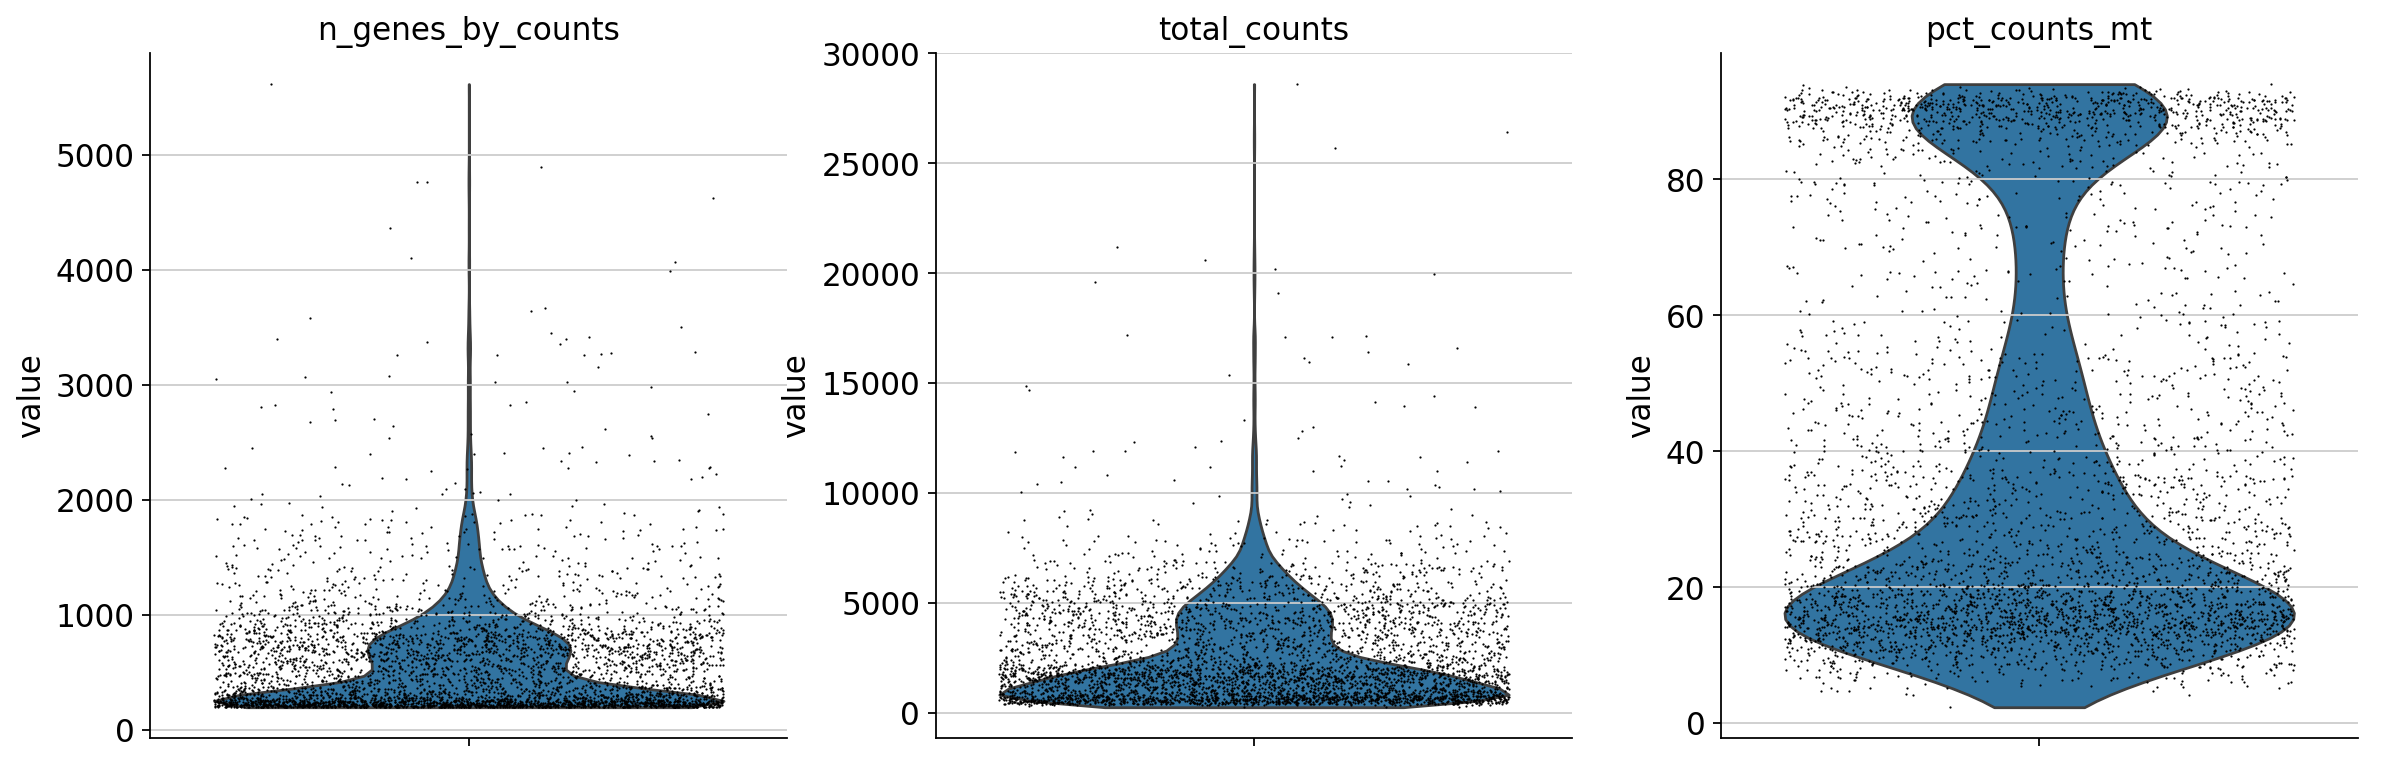

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

In [10]:
upper_lim_genes = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim_genes

1947.0599999999995

In [11]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim_genes]

In [12]:
upper_lim_counts = np.quantile(adata.obs.total_counts.values, .98)
upper_lim_counts

7285.199999999999

In [13]:
adata = adata[adata.obs.total_counts < 10000]

In [14]:
adata = adata[adata.obs.pct_counts_mt < 20]

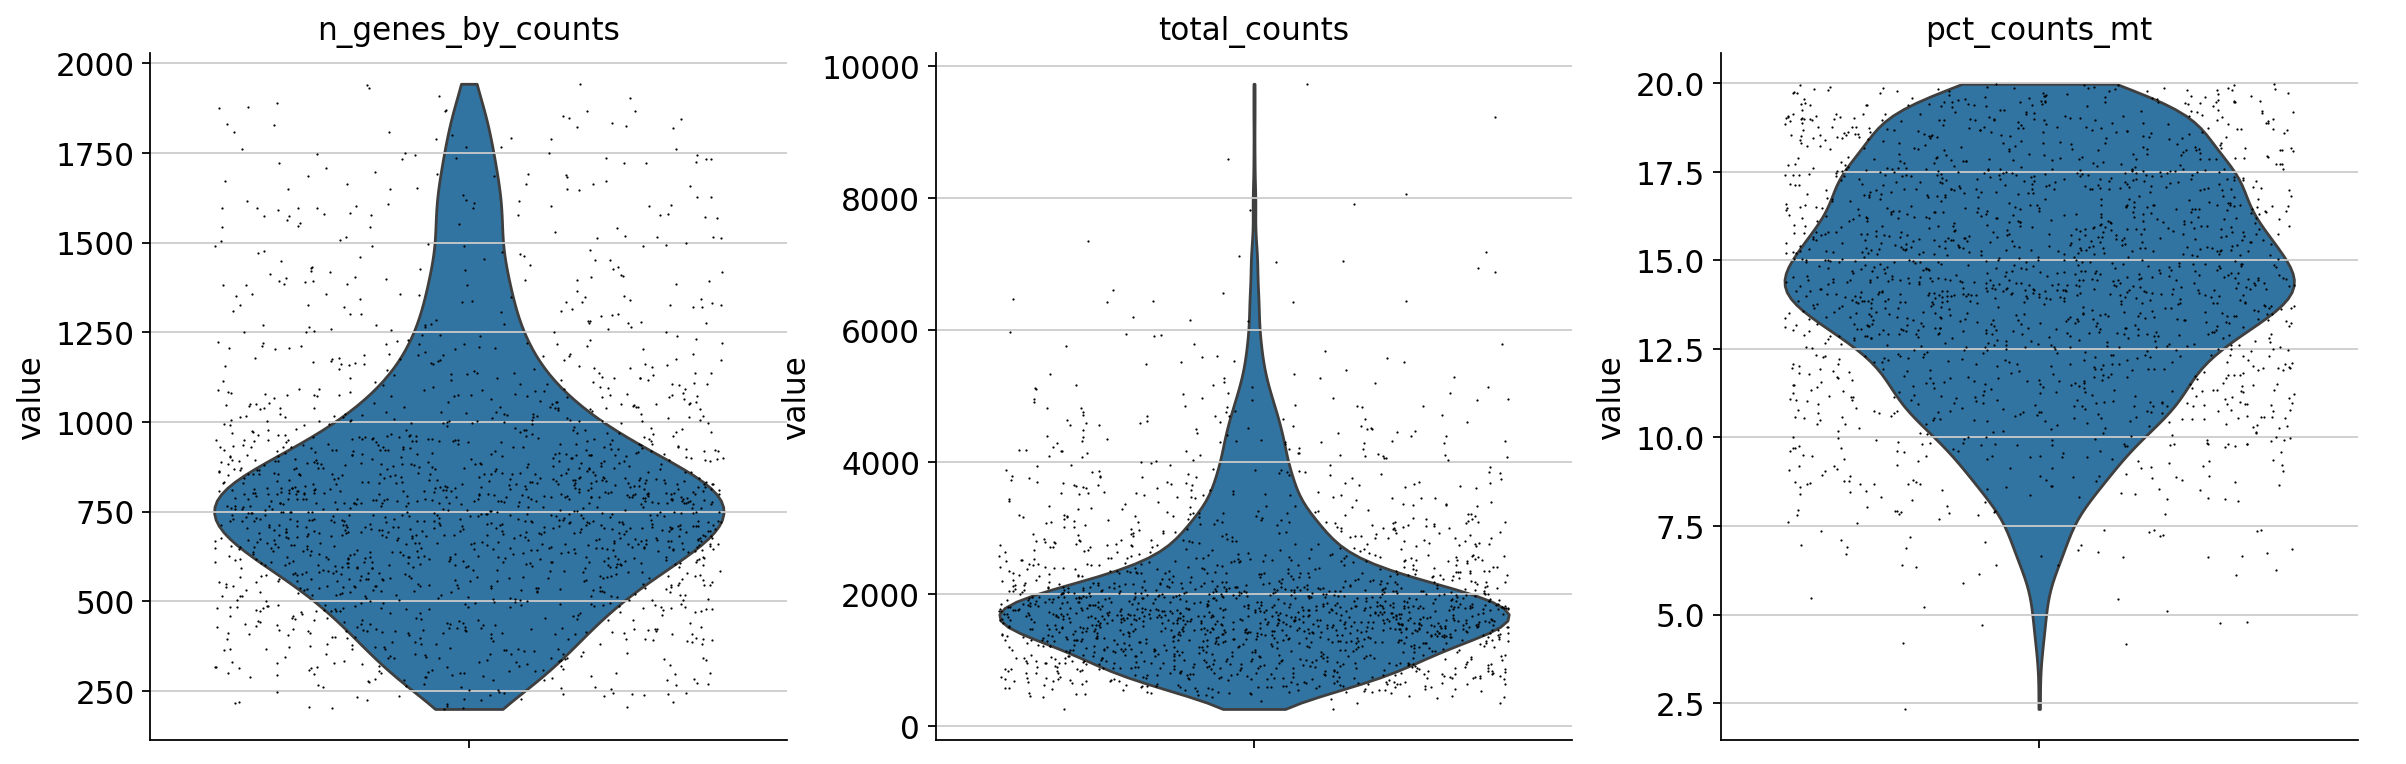

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

In [16]:
adata

View of AnnData object with n_obs × n_vars = 1724 × 16095
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid'

# Normalization

Normalization is a critical step in the preprocessing of single-cell data. It adjusts for variability in the data that arises from differences in sequencing depth, cell size or other technical factors. This step ensures that differences observed between cells are due to biological variation rather than technical remnants.

In Scanpy, the default method for normalization is **total-count normalization.** This approach involves scaling the raw counts for each cell by the total counts in that cell, followed by a logarithmic transformation to stabilize the data.

In [17]:
adata.X.sum(axis = 1)

matrix([[1939.],
        [5032.],
        [1637.],
        ...,
        [1711.],
        [1712.],
        [1057.]], dtype=float32)

**Scaling by Total Counts**

This step adjusts each cell's counts to account for differences in sequencing depth or total RNA content. The common practice is to scale the counts by a constant factor, typically 10,000 (often called "counts per ten thousand," or CPTT). This step creates a common baseline across all cells.

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:184: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
adata.X.sum(axis = 1)

matrix([[10000.   ],
        [10000.001],
        [10000.   ],
        ...,
        [10000.   ],
        [ 9999.999],
        [10000.   ]], dtype=float32)

**Logarithmic Transformation**

After scaling, Scanpy applies a logarithmic transformation to the scaled counts. This transformation helps stabilize variance, making the data less sensitive to extreme values and facilitating downstream analysis.

In [20]:
sc.pp.log1p(adata)

In [21]:
adata.X.sum(axis = 1)

matrix([[1758.7179],
        [2254.3665],
        [1675.0664],
        ...,
        [1594.5846],
        [1628.174 ],
        [1562.9828]], dtype=float32)

In [22]:
adata.raw = adata

# Clustering

In single-cell analysis, the goal is often to explore cellular diversity and identify unique cell types or states. Clustering allows us to categorize cells based on their gene expression profiles, providing insights into the composition of a sample. This step is critical for many downstream analyses, including identifying diferentially expressed genes and visualizing complex datasets.

Single-cell data typically has thousands of genes, making it high-dimensional. Before clustering, dimensionality reduction techniques PCA (Principal Component Analysis) and UMAP (Uniform Manifold Approximation and Projection) are used to reduce the data to a lower-dimensional space. This step helps focus on the most informative features while reducing noise.

There are several clustering methods, the most common are:

- K-means clustering
- Hierarchical Clustering
- Graph-based Clustering

Here we use a Graph-based Clustering. This is a common approach in scRNA-seq analysis that organizes cells into groups based on their connectivity in a graph structure. For this purpose, we employed **Leiden algorithm** which is a popular graph-based clustering method known for its efficiency, accuracy, and robustness. It is widely used in single-cell analysis due to its ability to find well-defined clusters in complex datasets.

### Leiden

Leiden starts by constructing a "neighbor graph," where each node represents a cell, and edges represent connections between cells based on their similarity (often measured using k-nearest neighbors or other distance metrics). The algorithm then applies a process called "community detection" to identify clusters of closely related cells within the graph.

Leiden is an improvement over the earlier Louvain algorithm, offering better cluster quality and avoiding some common issues, such as instability or disconnected clusters. It does this through several key steps:

- Node Partitioning: Leiden assigns cells (nodes) to initial clusters, creating a partition of the graph.
- Node Refinement: The algorithm refines the partition by evaluating the modularity (a measure of the strength of clusters) and moving nodes to improve modularity.
- Cluster Optimization: Leiden continues refining clusters until no further improvements can be made.

The final output is a set of clusters that represent distinct groups of cells, which can be used for downstream analyses like visualization, differential expression, or cell-type annotation.

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [24]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL669831.3,ENSG00000230021.9,139,False,139,0.031181,96.926139,141.0,False,0.057497,1.692383,-0.553464
MTND1P23,ENSG00000225972.1,1900,False,1900,1.143299,57.983193,5170.0,False,0.786593,1.928615,-0.402576
MTND2P28,ENSG00000225630.1,1524,False,1524,0.642415,66.298098,2905.0,False,0.611349,1.912279,-0.339875
MTCO1P12,ENSG00000237973.1,3691,False,3691,8.787483,18.376824,39737.0,False,2.238604,2.002842,-0.857025
MIR6723,ENSG00000278791.1,26,False,26,0.005971,99.425033,27.0,False,0.012843,1.805048,-0.174375
...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748.1,61,False,61,0.014374,98.651039,65.0,False,0.116762,1.863479,0.022230
AC240274.1,ENSG00000271254.6,12,False,12,0.002654,99.734631,12.0,False,0.023685,1.619186,-0.799752
U1-6,ENSG00000275405.1,6,False,6,0.001327,99.867315,6.0,False,0.004686,1.072328,-2.639791
AC233755.1,ENSG00000275063.1,7,False,7,0.007077,99.845201,32.0,False,0.017016,2.045175,0.633591


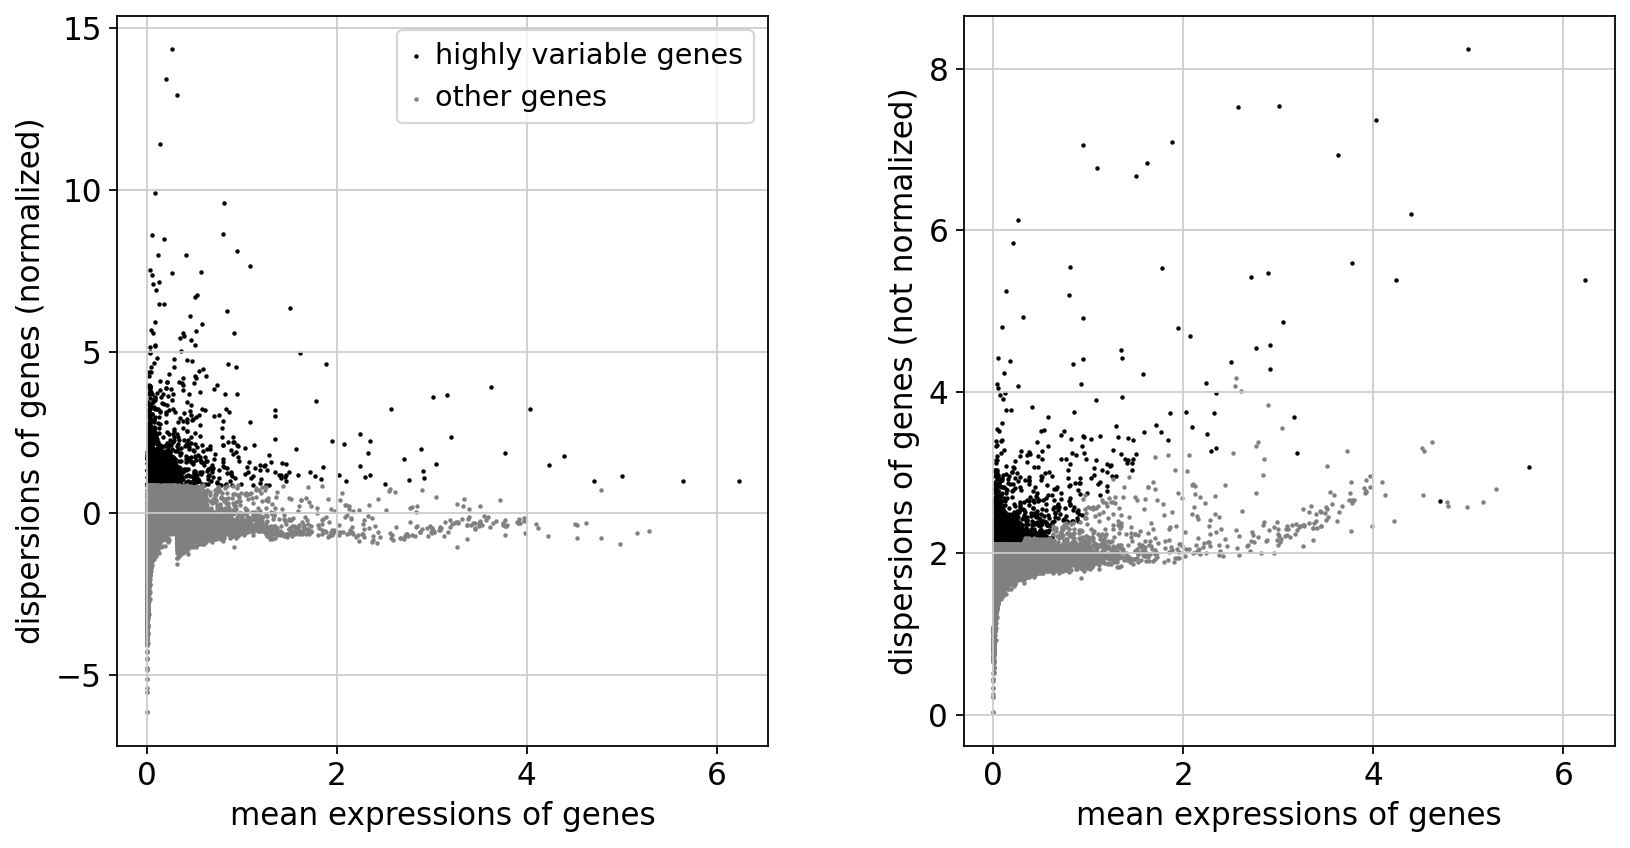

In [25]:
sc.pl.highly_variable_genes(adata)

In [26]:
adata = adata[:, adata.var.highly_variable]

In [27]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:640: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
sc.pp.scale(adata, max_value=10)

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

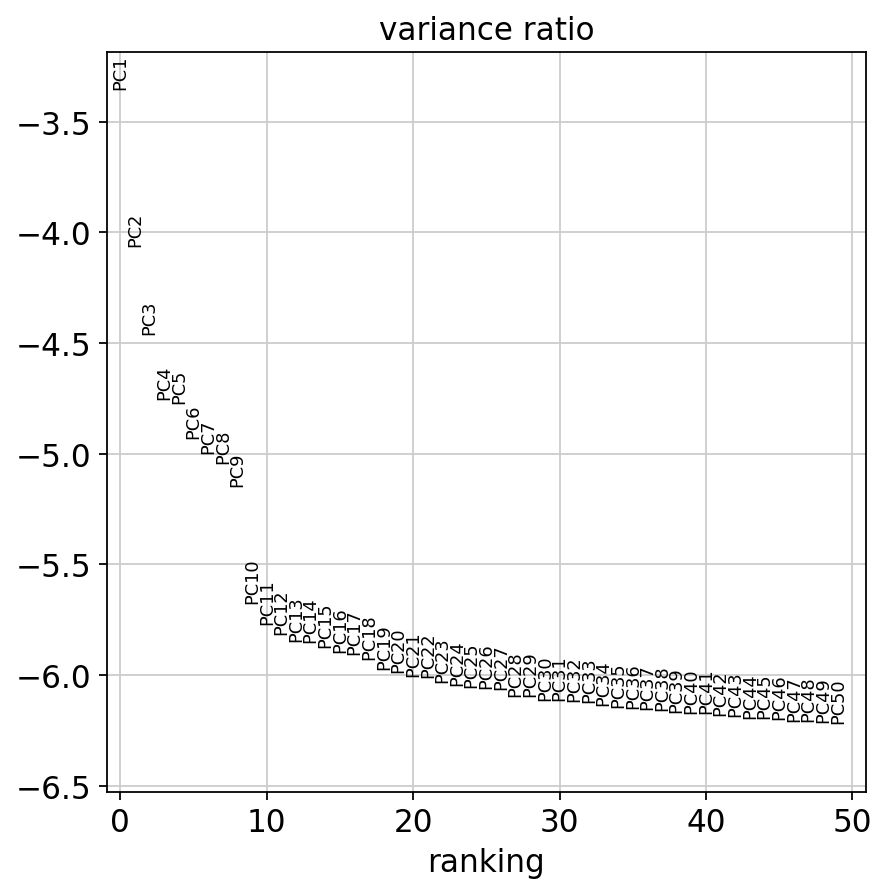

In [30]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [31]:
sc.pp.neighbors(adata, n_pcs = 30)

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


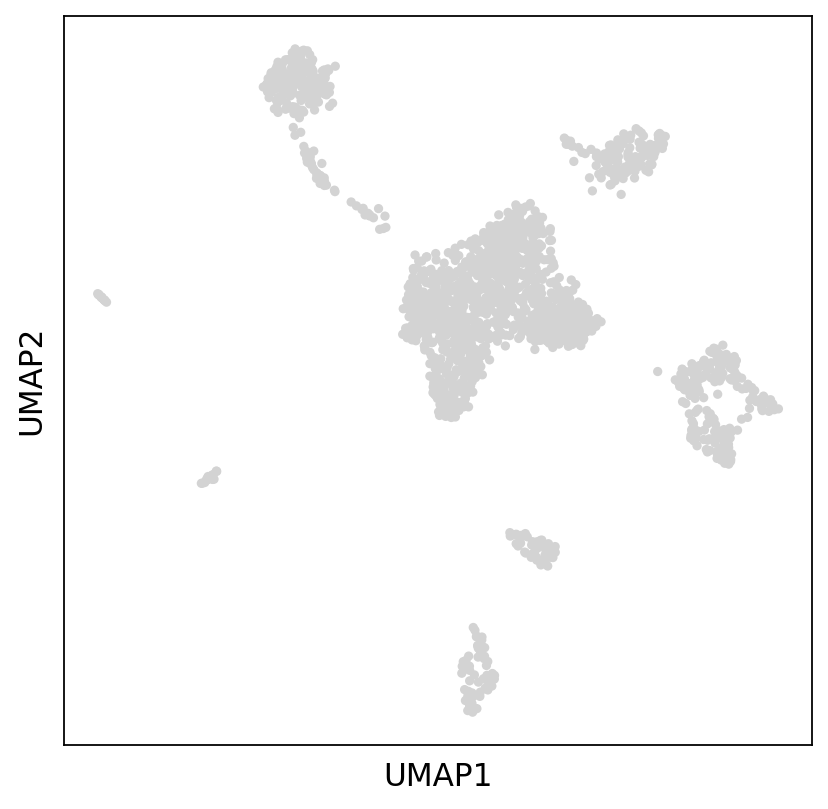

In [32]:
sc.tl.umap(adata)
sc.pl.umap(adata)

In [33]:
sc.tl.leiden(adata, resolution = 1)

In [34]:
adata.obs

,n_genes,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
CellID,,,,,,,
CCGGGATAGCTAGTGG,821,False,818,1939.0,364.0,18.772564,1
ACTGATGAGACAAGCC,1584,False,1577,5032.0,878.0,17.448332,11
GACTGCGGTCAGATAA,741,False,737,1637.0,276.0,16.860109,0
GGCGACTGTAGGAGTC,1338,False,1334,3086.0,323.0,10.466623,6
CCATTCGTCAACCATG,1246,False,1242,3220.0,404.0,12.546584,3
...,...,...,...,...,...,...,...
TTCGAAGTCCGTCATC,879,False,876,1724.0,233.0,13.515080,2
GGGATGAGTTAAAGAC,685,False,681,1322.0,197.0,14.901665,2
CTACCCATCTGTTGAG,704,False,703,1711.0,246.0,14.377557,5


/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


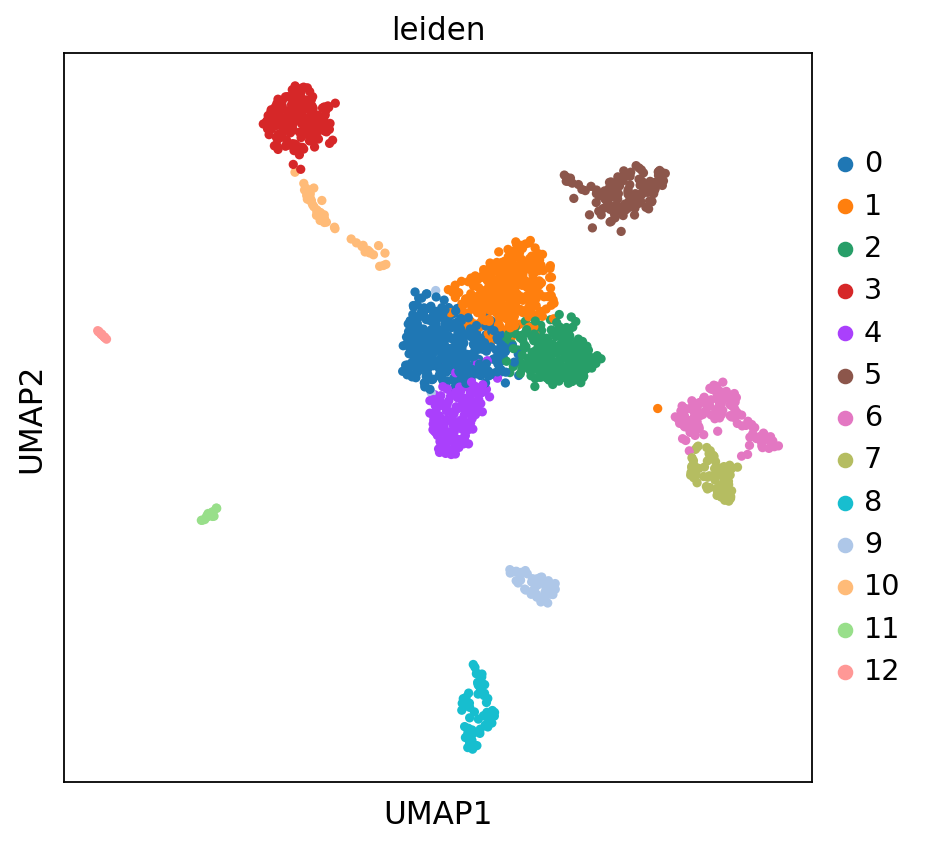

In [35]:
sc.pl.umap(adata, color=['leiden'])

In [36]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P1_QC.h5ad')